In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.regression import MeanAbsolutePercentageError
import math

# Data

In [2]:
df = pd.read_csv(".\\data\\google_stocks\\AABA_2006-01-01_to_2018-01-01.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [3]:
# make index date
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head(2)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA


Text(0.5, 1.0, 'Low')

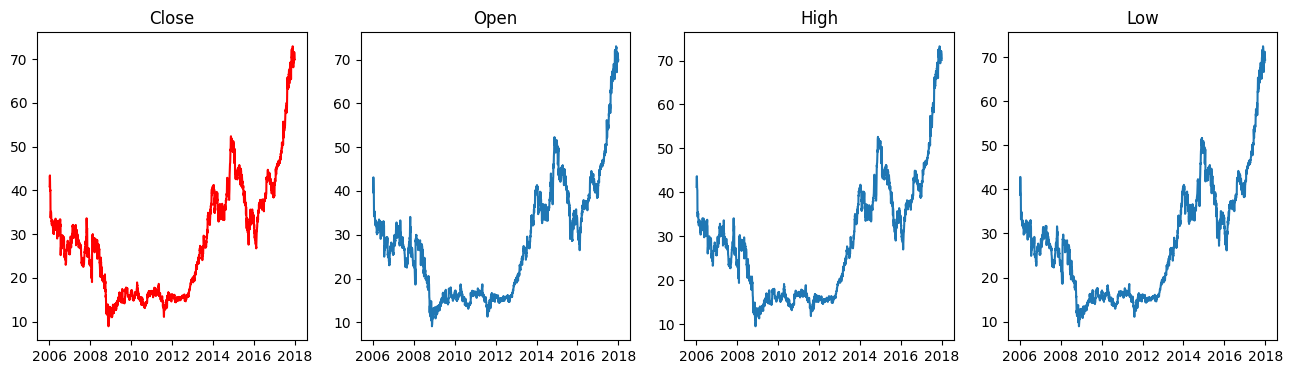

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(df.index, df['Close'], color='r')
ax[1].plot(df.index, df['Open'])
ax[2].plot(df.index, df['High'])
ax[3].plot(df.index, df['Low'])

ax[0].set_title('Close')
ax[1].set_title('Open')
ax[2].set_title('High')
ax[3].set_title('Low')

In [5]:
df = df['2009-01-01':]
df

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2009-01-02,12.17,12.85,12.12,12.85,10213787,AABA
2009-01-05,12.72,13.01,12.39,12.86,12029058,AABA
2009-01-06,12.96,13.24,12.88,13.00,10173926,AABA
2009-01-07,12.71,13.16,12.45,12.71,25302285,AABA
2009-01-08,12.37,13.07,12.31,13.07,14348008,AABA
...,...,...,...,...,...,...
2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA


In [7]:
print(df.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


In [12]:
data_close = df.loc[:, 'Close'].to_frame(name='Close')
data_close

,Close
Date,
2009-01-02,12.85
2009-01-05,12.86
2009-01-06,13.00
2009-01-07,12.71
2009-01-08,13.07
...,...
2017-12-22,71.58
2017-12-26,69.86
2017-12-27,70.06


In [13]:
# normalize the values
scaler = MinMaxScaler(feature_range=(0, 1))
data_close['Close'] = scaler.fit_transform(data_close)

In [14]:
data_close

,Close
Date,
2009-01-02,0.029716
2009-01-05,0.029877
2009-01-06,0.032138
2009-01-07,0.027455
2009-01-08,0.033269
...,...
2017-12-22,0.978198
2017-12-26,0.950420
2017-12-27,0.953650


In [15]:
def create_sequences(data, window_size, predicted_size, step_size):
    '''Function for creating windows'''
    X, y = [], []
    for i in range(0, len(data) - window_size - predicted_size, step_size):
        window = data.iloc[i : i + window_size]
        predicted_period = data.iloc[i + window_size : i + window_size + predicted_size]
        X.append(window.values)
        y.append(predicted_period.values)
    return np.array(X), np.array(y)


window_size = 40
# Prediction window
predicted_size = 3
# We don`t use overlap (it is equal to window_size)
train_val_step = window_size

# Create windows
X, y = create_sequences(data_close, window_size, predicted_size, train_val_step)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

n = len(X)
X_train, y_train = torch.tensor(X[0:int(n*0.65)], dtype=torch.float32), torch.tensor(y[0:int(n*0.65)], dtype=torch.float32)
X_val, y_val = torch.tensor(X[int(n*0.65):int(n*0.85)], dtype=torch.float32), torch.tensor(y[int(n*0.65):int(n*0.85)], dtype=torch.float32)
X_test, y_test = torch.tensor(X[int(n*0.85):], dtype=torch.float32), torch.tensor(y[int(n*0.85):], dtype=torch.float32)

print("Размерность обучающей выборки: " + str(X_train.shape) + str(y_train.shape))
print("Размерность валидационной выборки: " + str(X_val.shape) + str(y_val.shape))
print("Размерность тестовой выборки: " + str(X_test.shape) + str(y_test.shape))

Размерность обучающей выборки: torch.Size([36, 40, 1])torch.Size([36, 3, 1])
Размерность валидационной выборки: torch.Size([11, 40, 1])torch.Size([11, 3, 1])
Размерность тестовой выборки: torch.Size([9, 40, 1])torch.Size([9, 3, 1])


Text(0, 0.5, 'Price')

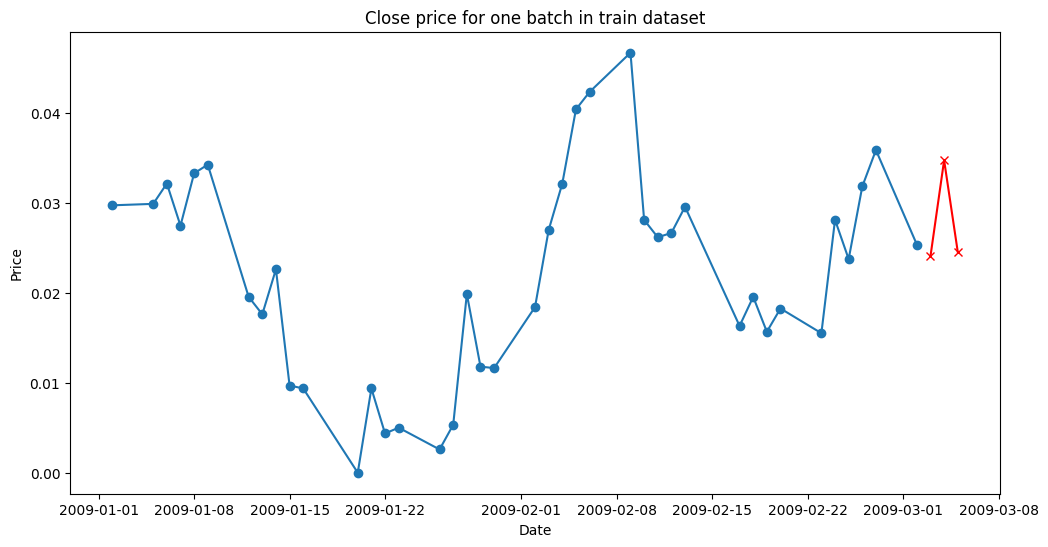

In [16]:
plt.figure(figsize=(12,6))
plt.plot(df.index[:window_size], X_train[0], marker='o')
plt.plot(df.index[window_size : window_size + predicted_size], y_train[0], color='r', marker='x')
plt.title('Close price for one batch in train dataset')
plt.xlabel('Date')
plt.ylabel('Price')

# LSTM

In [17]:
input_dim = 1
hidden_dim = 30
num_layers = 1
out_dim = predicted_size
seq_length = window_size

batch_size = 15
learning_rate = 0.01
epochs = 250
metric = MeanAbsolutePercentageError()

In [18]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size)
val_dataloader = DataLoader(val_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

In [19]:
class LSTM_Model(nn.Module):
    """
        LSTM(input_size, hidden_size, num_layers)
        if batch_first=True:
            h0(num_layers, batch_size, hidden_dim)
            c0(num_layers, batch_size, hidden_dim)
            input(batch_size, seq_length, input_dim)
            output(batch_size, seq_lendth, hidden_dim)

        input_dim: number of features
        hidden_dim: length of memory vector
        num_layers: number of layers in lstm
        out_dim: length of predicted values
        seq_length: number of important last values
    """
    
    def __init__(self, input_dim, hidden_dim, out_dim, num_layers=1):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(num_layers, batch_size, hidden_dim)

        # output: torch.Size([batch_size, seq_length, hidden_dim])
        output, (hn, cn) = self.lstm(x, (h0, c0))
        
        # output: torch.Size([batch_size, hidden_dim])
        output = self.fc(output[:, -1, :])

        # output: torch.Size([batch_size, hidden_dim, 1])
        output = output.unsqueeze(-1)
        return output

In [20]:
class ModelCompilation():
    def __init__(self,
                model, 
                optimizer, 
                loss_function, 
                metric):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.metric = metric

        # Initialize best validation error to infinity so improvement can be tracked
        self.best_val_loss = float('inf') 

        # Dictionary for storing metrics across all epoches
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "test_loss": [], 
            "test_targets": [],
            "test_preds": [],
            "mape": [],
            "log": []
        }

        # List for storing the model's predictions on the test
        self.mlp_preds = []

    def fit(self, train_dataloader, val_dataloader, epochs):
        for epoch in tqdm(range(epochs)):
            model.train()
            for train_data, val_data in zip(train_dataloader, val_dataloader):
                x, y = train_data[0], train_data[1]
                x_val, y_val = val_data[0], val_data[1]

                self.optimizer.zero_grad()
                y_pred = self.model(x)

                loss = self.loss_function(y_pred, y)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    y_pred_val = self.model(x_val)          
                    val_loss = self.loss_function(y_pred_val, y_val)
                    
            self.history["train_loss"].append(loss.detach().numpy())
            self.history["val_loss"].append(val_loss.detach().numpy())

            if val_loss < self.best_val_loss:
                self.history["log"].append(f"Epoch({epoch}):Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}. Saving weights... \n")
                self.best_val_loss = val_loss # update the value of the best validation error
                torch.save(self.model.state_dict(), 'best_lstm.pth') # save model weights

        return self.model 

    
    def test(self, test_dataloader, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
        self.model.eval()
        for test_data in test_dataloader:
            x_test, y_test = test_data[0], test_data[1]
            with torch.no_grad():
                y_pred_test = self.model(x_test)          
                test_loss = self.loss_function(y_pred_test, y_test)
                mape = self.metric(y_pred_test, y_test)

            self.history["test_targets"].extend(y_test.flatten().detach().numpy())
            self.history["test_preds"].extend(y_pred_test.flatten().detach().numpy())
            
            self.history["test_loss"].append(test_loss.detach().numpy())
            self.history["mape"].append(mape.detach().numpy())

        print(f'Test Loss: {self.history["test_loss"][-1]:.2f}')
        print(f'Metric MAPE: модель ошибается в среднем на {self.history["mape"][-1]*100:.2f}%')

        # loss_range = range(1, len(self.history["test_loss"]) + 1)
        # mape_range = range(1, len(self.history["mape"]) + 1)
        y_range = range(1, len(self.history["test_targets"]) + 1)

        # Plotting graphs
        fig, ax = plt.subplots(figsize=(12, 5))
        # Set the background color of the graph
        fig.patch.set_facecolor('#2a2d31')  # Background color of the figure
        ax.set_facecolor('#2a2d31')         # Axes background color

        # Setting the color of the axes
        ax.spines['left'].set_color('#DAF7A6')    # Upper Axis Color
        ax.spines['bottom'].set_color('#DAF7A6')   # Bottom Axis Color
        ax.tick_params(axis='both', which='both', labelcolor='#FFFFFF')
        
        plt.plot(y_range, self.history["test_targets"], label="test targets", color='#b7fed6')
        plt.plot(y_range, self.history["test_preds"], label="test predicts", color='#DAF7A6')
        plt.title("Predicted price")
        plt.xlabel("Epoch")
        plt.ylabel("Price")
        plt.legend()

        '''
        fig, axs = plt.subplots(1, 3, figsize=(12, 5))  
        axs[0].plot(loss_range, self.history["test_loss"], label="Test Loss")
        axs[0].set_title("Loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()

        
        axs[1].plot(mape_range, self.history["mape"], label="MAPE")
        axs[1].set_title("Metric MAPE")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Metric MAPE")
        axs[1].legend()

        axs[2].plot(y_range, self.history["test_targets"], label="test targets")
        axs[2].plot(y_range, self.history["test_preds"], label="test predicts", color='r')
        axs[2].set_title("Predicted values")
        axs[2].set_xlabel("Epoch")
        axs[2].set_ylabel("Price")
        axs[2].legend()
        '''
        

    def plot_metrics(self):
        epochs_range = range(1, len(self.history["train_loss"]) + 1)

        # Plotting graphs
        fig, ax = plt.subplots(figsize=(12, 5))
        # Set the background color of the graph
        fig.patch.set_facecolor('#2a2d31')
        ax.set_facecolor('#2a2d31')

        # Setting the color of the axes
        ax.spines['left'].set_color('#DAF7A6')
        ax.spines['bottom'].set_color('#DAF7A6')
        ax.tick_params(axis='both', which='both', labelcolor='#FFFFFF')

        # Plotting the losses graph
        plt.plot(epochs_range, self.history["train_loss"], label="Train Loss", color='#b7fed6')
        plt.plot(epochs_range, self.history["val_loss"], label="Validation Loss", color='#DAF7A6')
        plt.title("График изменения ошибки модели", color='#FFFFFF')
        plt.xlabel("Эпохи", color='#FFFFFF')
        plt.ylabel("Ошибка", color='#FFFFFF')
        plt.legend()

    def log(self):
        for i in self.history['log']:
            print(i)

In [21]:
model = LSTM_Model(input_dim, hidden_dim, out_dim, num_layers)
optimizer = Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

model_compilation = ModelCompilation(model, optimizer, criterion, metric)

100%|███████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 100.78it/s]


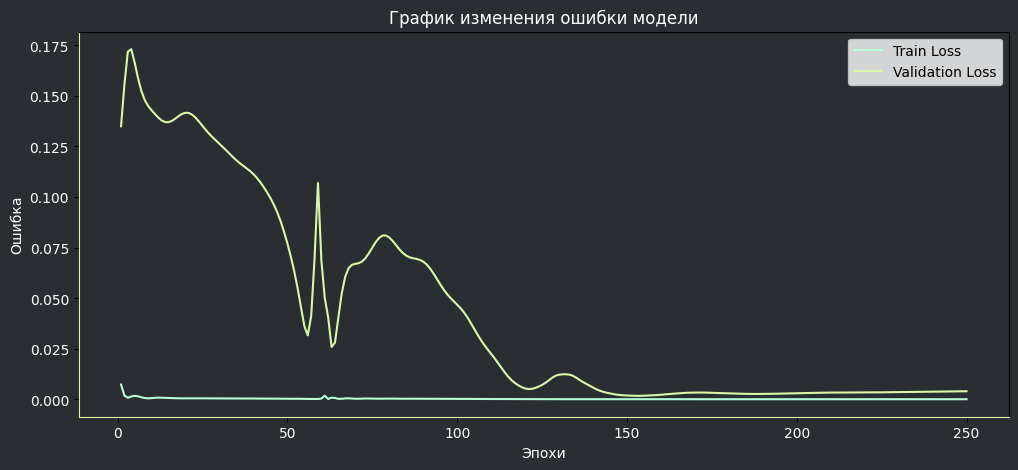

In [22]:
model_compilation.fit(train_dataloader, val_dataloader, epochs)
model_compilation.plot_metrics()

In [23]:
model_compilation.log()

Epoch(0):Validation loss improved from inf to 0.1350. Saving weights... 

Epoch(25):Validation loss improved from 0.1350 to 0.1331. Saving weights... 

Epoch(26):Validation loss improved from 0.1331 to 0.1312. Saving weights... 

Epoch(27):Validation loss improved from 0.1312 to 0.1295. Saving weights... 

Epoch(28):Validation loss improved from 0.1295 to 0.1279. Saving weights... 

Epoch(29):Validation loss improved from 0.1279 to 0.1263. Saving weights... 

Epoch(30):Validation loss improved from 0.1263 to 0.1247. Saving weights... 

Epoch(31):Validation loss improved from 0.1247 to 0.1231. Saving weights... 

Epoch(32):Validation loss improved from 0.1231 to 0.1214. Saving weights... 

Epoch(33):Validation loss improved from 0.1214 to 0.1197. Saving weights... 

Epoch(34):Validation loss improved from 0.1197 to 0.1181. Saving weights... 

Epoch(35):Validation loss improved from 0.1181 to 0.1167. Saving weights... 

Epoch(36):Validation loss improved from 0.1167 to 0.1154. Saving wei

Test Loss: 0.01
Metric MAPE: модель ошибается в среднем на 8.65%


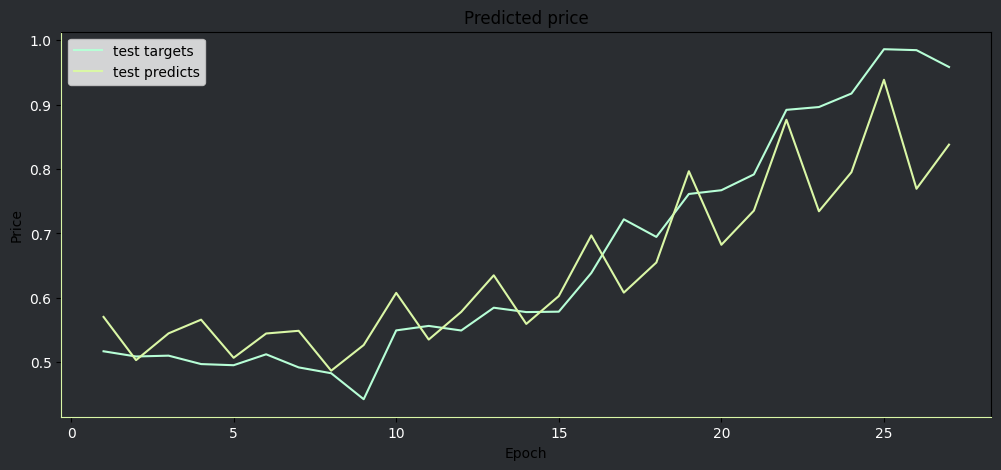

In [24]:
checkpoint_path = "C:\\Users\\Chiki\\jupyter\\masters_course\\best_lstm.pth"
model_compilation.test(test_dataloader, checkpoint_path)